##### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

#################
# My notebook issues
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
sys.path.append('home/egupta/.local/bin')

##############

import os
import numpy as np
import scipy.stats as ss
import networkx as nx
import csv 
import numpy as np
import seaborn as sns
from pandas import DataFrame
from scipy.optimize import curve_fit
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline


##qtensor imports
import qtensor
from qtensor import QAOA_energy
from qtensor import parameter_optimization as popt
import torch

2021-07-25 10:36:31,021- WARNING•	QuickBB solver is unavailable
2021-07-25 10:36:31,023- WARNING•	Tamaki solver is unavailable: No path /home/egupta/.local/lib/python3.7/site-packages/thirdparty/tamaki_treewidth


# Data Collection Details

y = 5

x = 11*y

Use data stored in drive to generate subgraph_similarity_metric vs actual similarity for random graphs

All random graphs have 20 nodes but they differ in how many even degree nodes they have. There are a total of x graphs-- y of them with 0 even nodes, y with 2 even degree nodes , ..., y with all 20 even degree nodes. (Generating 20-node graphs with say odd number of even degree nodes like 3 even degree nodes was not possible ---it raised networkx.exception.NXUnfeasible )

Also when I say y graphs with same even degree nodes, they also have same degree sequence. But they are different i.e. non-isomorphic/

** Now debugging why some graphs, having different parity have high tranferability **

# Tranferability Matrices for Subgraphs
one of them uses the averaging technique, the other uses the best of 20 trick

# Why Mutual Tranferability
In the tranferability paper, we saw patterns in how even and odd subgraphs tranfer. But there was an important claim underlying that blue colormap: all the subgraphs was mutually tranferable. Well, that fact is trvial, but not so in our case, where we are not comparing subgraphs but larger random graphs. 

I'm calling a graph odd based on the number of even degree nodes it has. But that does not mean, like an odd subgraph, it is mutually tranferable. Let me repeat: Odd subgraphs are mutually tranferable. But "odd" graphs are not necessarily so!

Now in the paper, there were 3 conditions for tranferability:
1. Donor graph is mutually transferable
2. Acceptor graph is mutually transferable
3. All subgraphs in donor graph are tranferable to all subgraphs in acceptor graph.

My **hypothesis** is that conditions #1 and #2 affect number #3. Specifically, I claim that mutual tranferability of donor and acceptor graphs affects how well we can predict similarity between the pair. (i.e. **how close subgraph similarity metric is to actualy similarity**)

# Tranferability  Matrix for random subgraphs

In [2]:
def sub_all(d1, d2, draw=False):
    # returns a list of subgraphs of all graphs with nodes of the central edge having degree d1 and d2
    A = np.zeros((d1 + d2, d1 + d2))
    A[d1 + 1:, d1] = 1
    A[:d1 - 1, d1 - 1] = 1
    A[d1 - 1, :d1 - 1] = 1
    A[d1, d1 + 1:] = 1
    A[d1, d1 - 1] = 1
    A[d1 - 1, d1] = 1
    
    g = nx.from_numpy_matrix(np.array(A))

    g_list = [g]
    for i in range(min(d1, d2) - 1):
        g = g_list[i]
        g_list.append(nx.contracted_nodes(g, i, i + d1 + 1))
    # relabel center edge as (0, 1)
    for i, g in enumerate(g_list):
        g_list[i] = qtensor.tools.lightcone_orbits.relabel_edge_first(g, (d1 - 1, d1))
        if draw:
            nx.draw_kamada_kawai(g)
            plt.show()
    return g_list

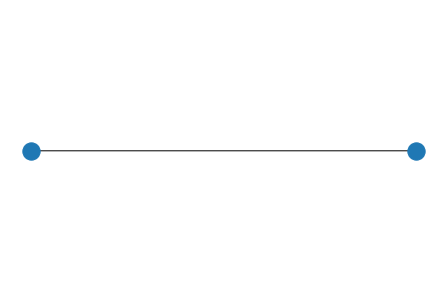

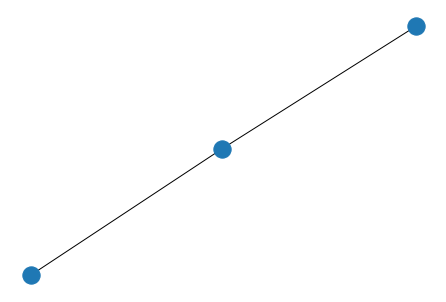

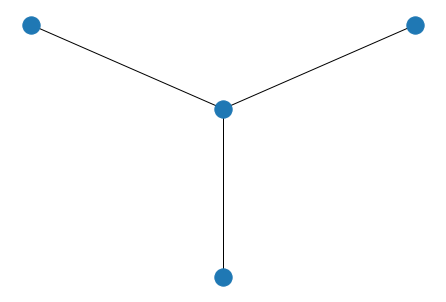

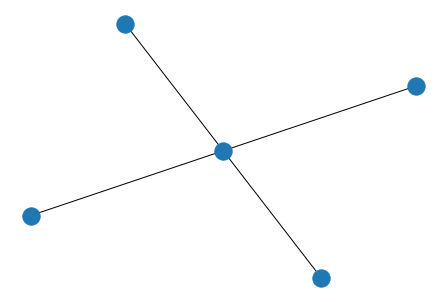

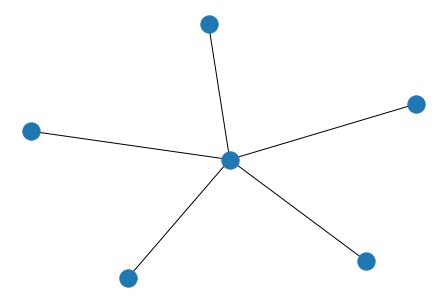

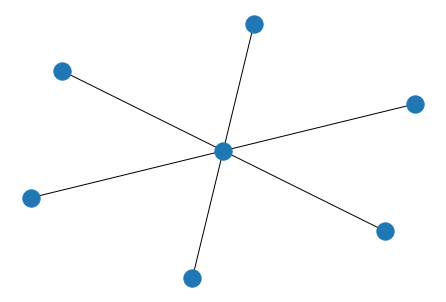

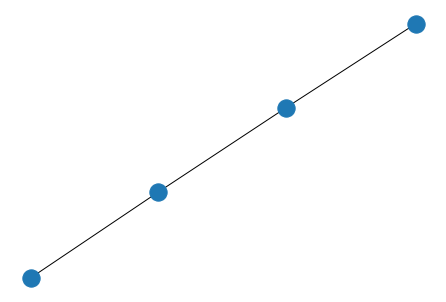

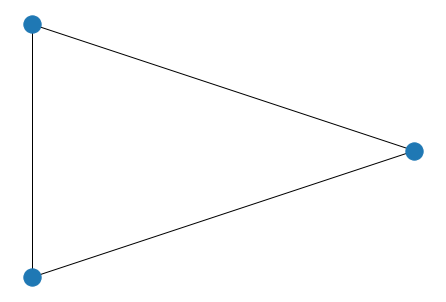

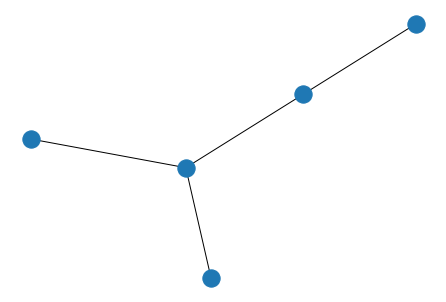

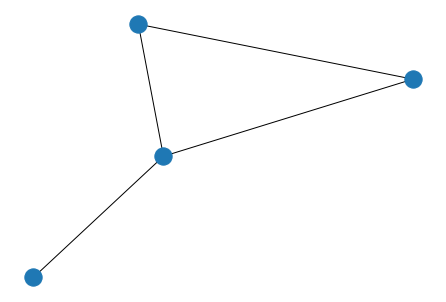

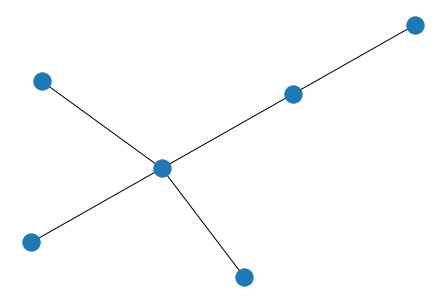

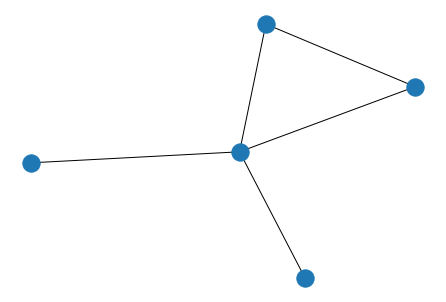

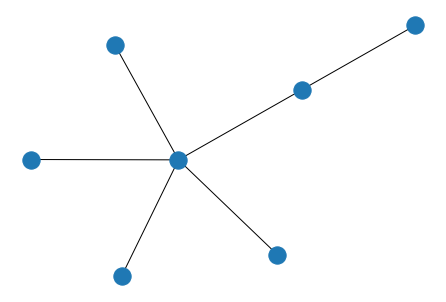

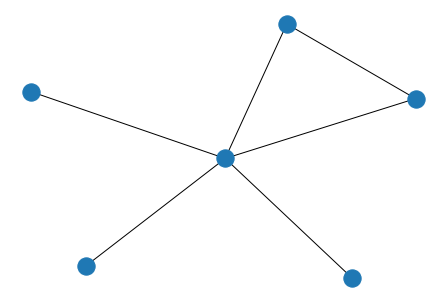

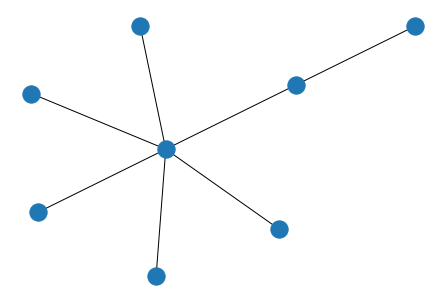

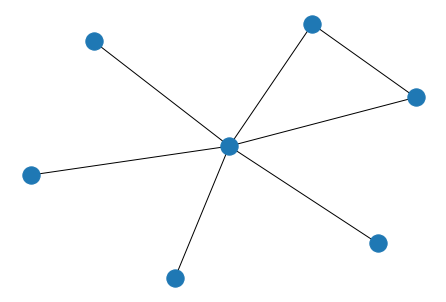

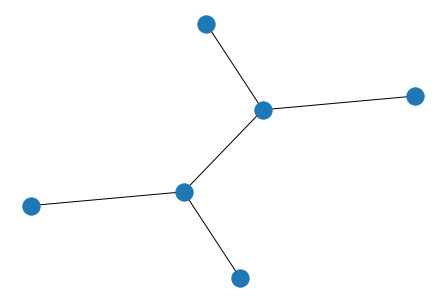

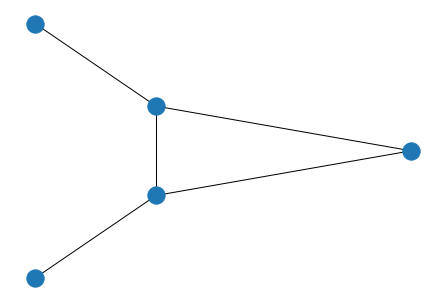

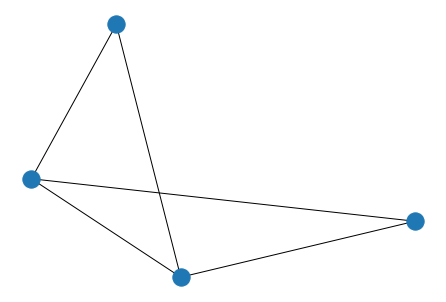

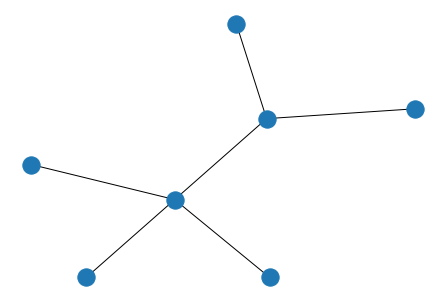

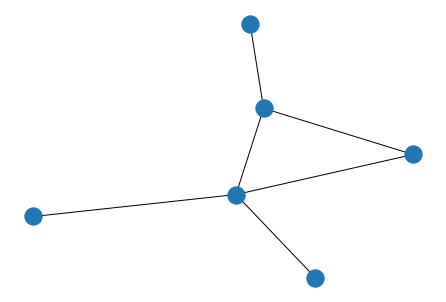

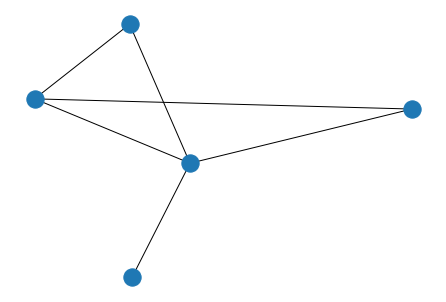

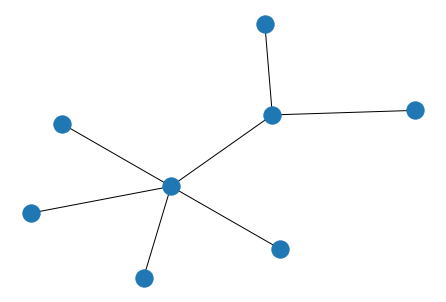

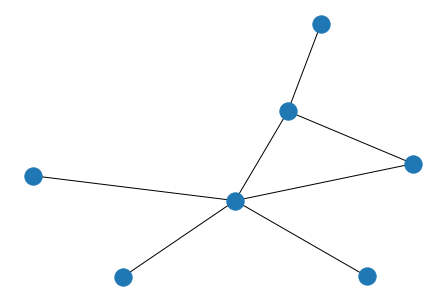

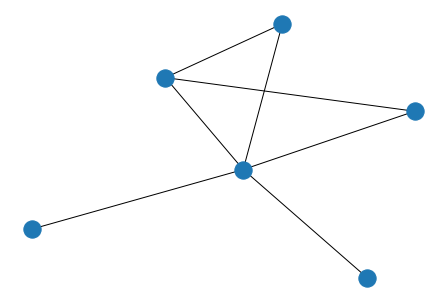

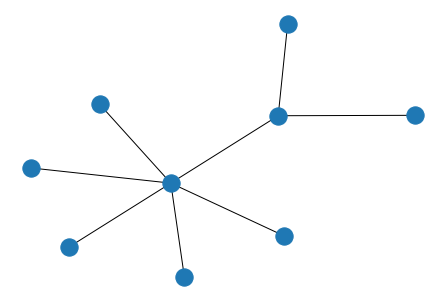

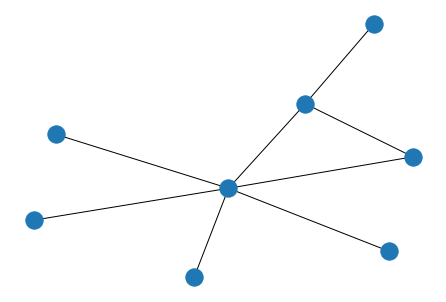

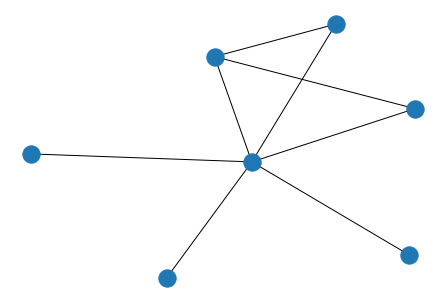

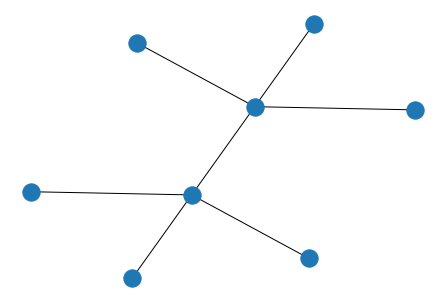

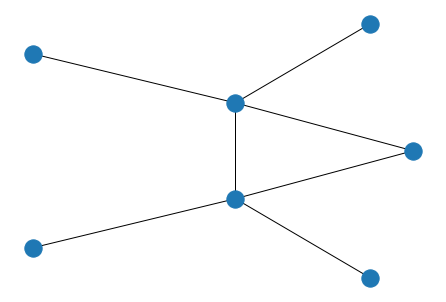

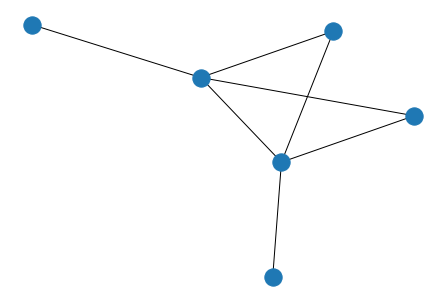

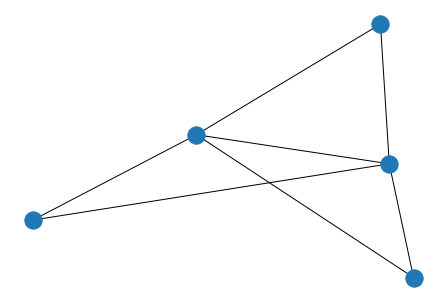

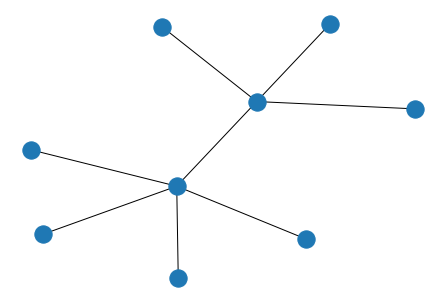

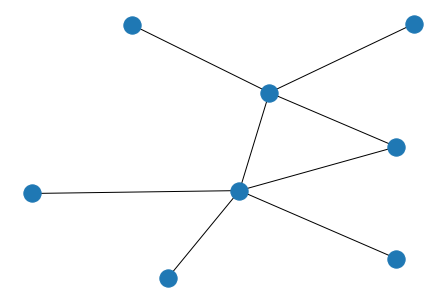

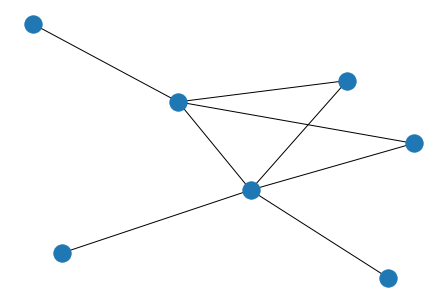

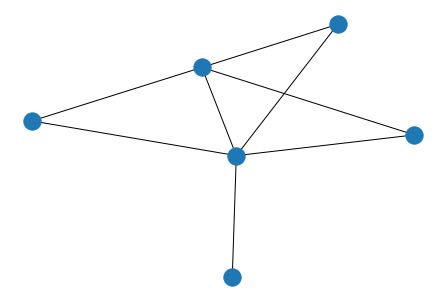

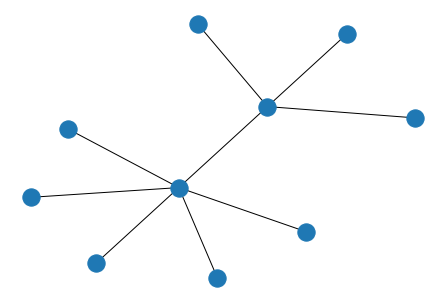

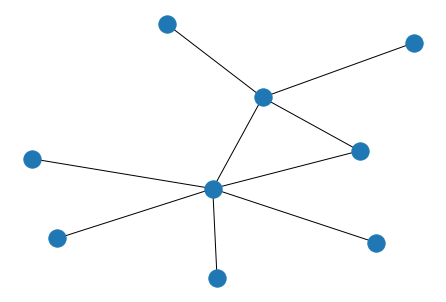

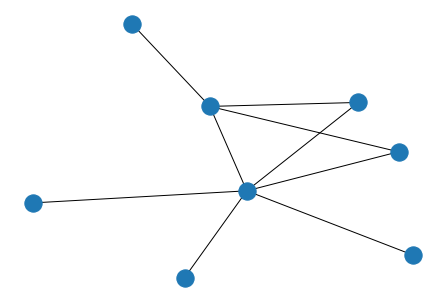

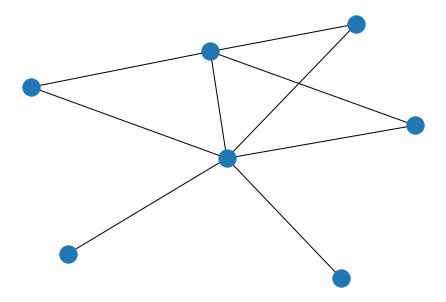

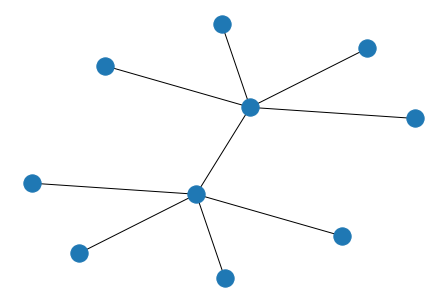

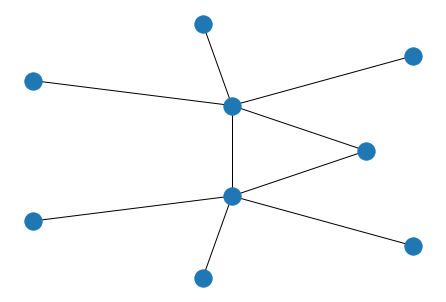

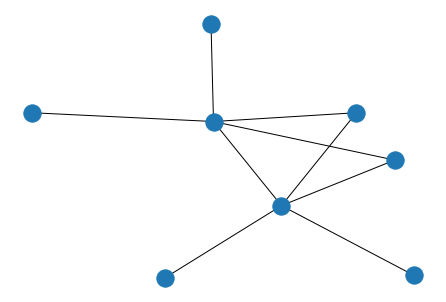

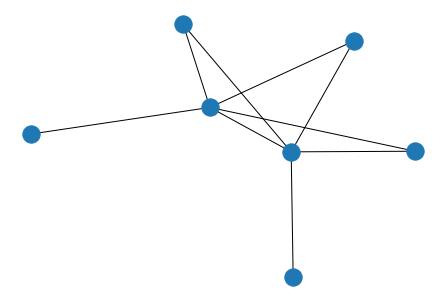

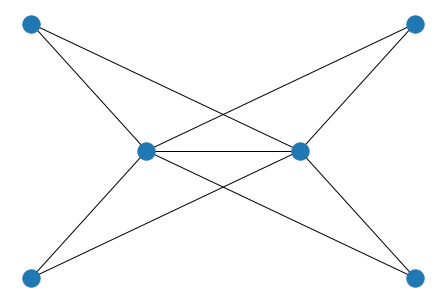

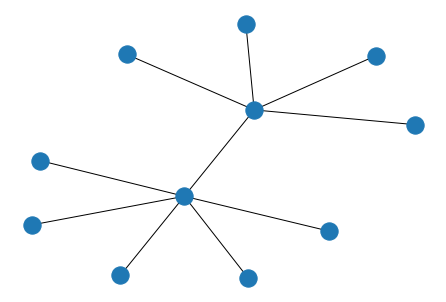

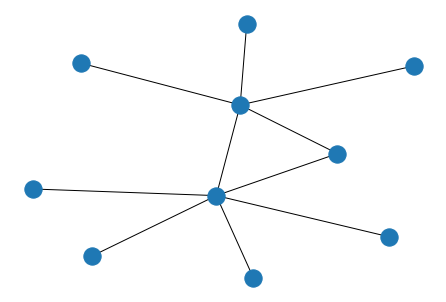

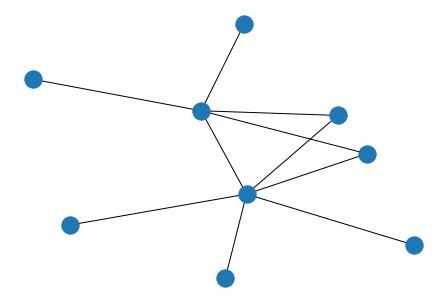

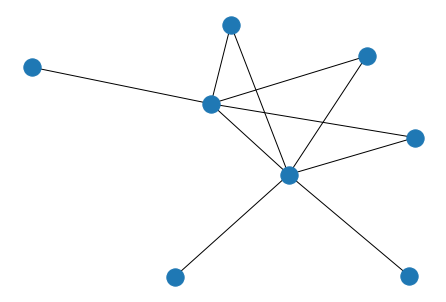

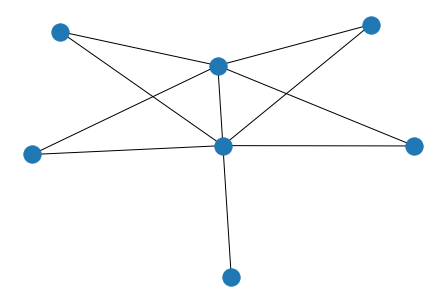

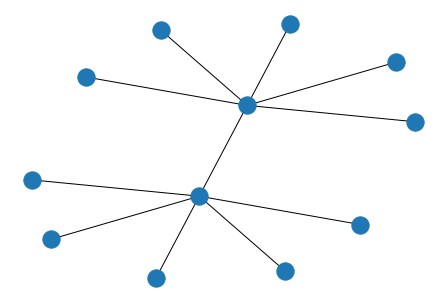

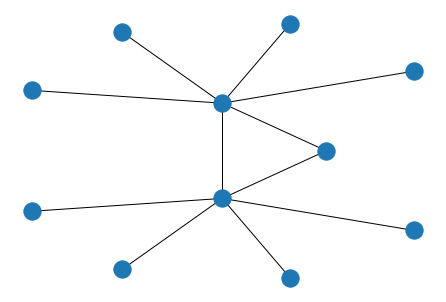

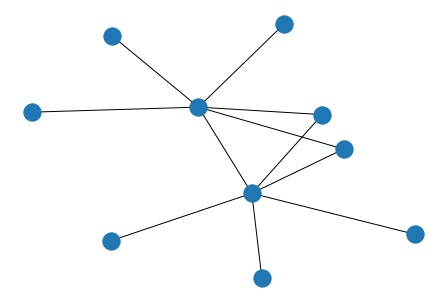

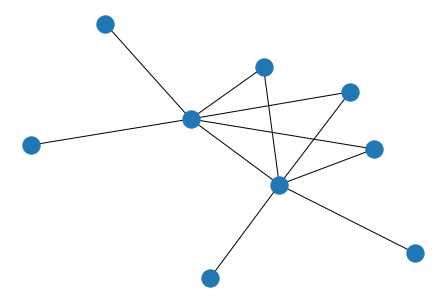

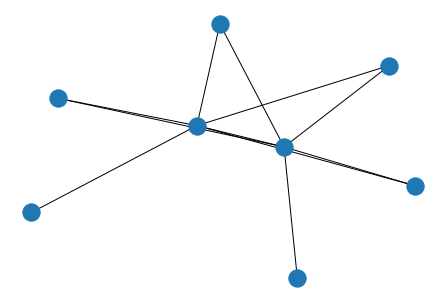

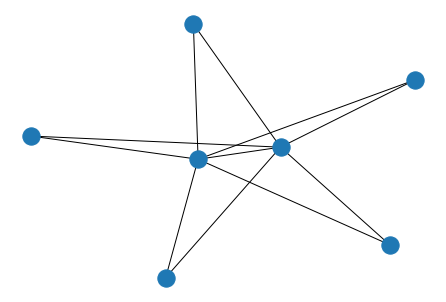

In [3]:
#generating all subgraphs first 
d_min = 1
d_max = 6
g_all = []
for i in range(d_min, d_max + 1):
    for j in range(i, d_max + 1):
        g_sub_ij = sub_all(i, j, draw=True)
        g_all += g_sub_ij

Get Data from a text file

In [4]:
file1 = open("/home/egupta/Documents/Eesh's Experiments/Transferability Matrices/transferability_matrix_random_subgraphs_6.txt")
file2 = open("/home/egupta/Documents/Eesh's Experiments/Transferability Matrices/direct_transferability_matrix_random_subgraphs_6.txt")

In [5]:
tranf_mat_orig = np.loadtxt(file1).reshape(56,56)
tranf_mat_mod = np.loadtxt(file2).reshape(56,56)

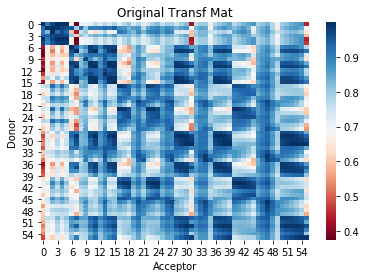

In [6]:
df = DataFrame(tranf_mat_orig)#, index=Index, columns=Cols)
sns.heatmap(df, annot=False, cmap="RdBu")
plt.title("Original Transf Mat")
plt.ylabel('Donor')
plt.xlabel('Acceptor')
plt.show()

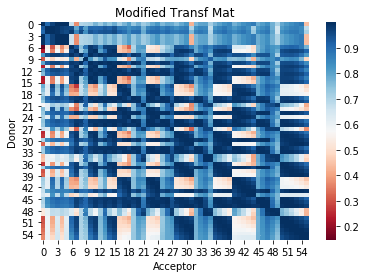

In [7]:
df = DataFrame(tranf_mat_mod)#, index=Index, columns=Cols)
sns.heatmap(df, annot=False, cmap="RdBu")
plt.title("Modified Transf Mat")
plt.ylabel('Donor')
plt.xlabel('Acceptor')
plt.show()

In [8]:
tranf_mat = tranf_mat_orig

# Identifying Subgraphs of a Graph

In [9]:
def find_index(g, subgraphs):
    """
    finds index of subgraph g is isomorphic with
    """
    i = 0
    while i<len(subgraphs):
        if nx.is_isomorphic(g, subgraphs[i]):
            return i
        i+=1
    print('error: could not find subgraph')
    return -1

In [10]:
def find_subgraphs(G):
  '''
  Input: A graph G
  Output: A dictionary containg subgraphs and their frequency in G
  '''
  edges_done = []
  subgraphs = {}

  vertices = G.nodes
  for v1 in vertices:
    ######print('----------------------------------------')
    ######print('Parent checking for vertex ' +str(v1) )
    neighbors = nx.all_neighbors(G,v1)
    ######print(neighbors)
    #iterate over edges
    for v2 in neighbors:
      ######print('Childchecking for vertex ' +str(v2) )
      ##if already there
      if (v1,v2) in edges_done:
        #######print('Already looked at')
        continue
      ##add if not there
      else:
        ######print('Not looked at')
        edges_done.append((v1,v2))
        edges_done.append((v2,v1))
      
      neighbors1 = nx.all_neighbors(G,v1)
      neighbors2 = nx.all_neighbors(G, v2)

      subg_edge_set = []
      for v in neighbors1:
        #######print(v)
        edge = (v1, v)
        subg_edge_set.append(edge)

      for v in neighbors2:
        ######print(v)
        if v is not v1:
          edge = (v2, v)
          subg_edge_set.append(edge)

      ##creating the subgraph
      H = G.edge_subgraph(subg_edge_set)

      ##check if isomorphic with any other subgraphs
      iso = False
      subgraphs_arr = subgraphs.keys()
      for subgraph in subgraphs_arr:
        if nx.is_isomorphic(H, subgraph):
          #######print('is isomorphic')
          subgraphs[subgraph] +=1
          iso = True
          break
      if iso == False:
        #######print('---------------Adding a subgraph--------------------')
        subgraphs[H] = 1
        ######print(subgraphs)
  return subgraphs

# Similiarity between 2 graphs

In [11]:
def similarity(G1, G2, subgraphs = g_all, tranf_mat = tranf_mat):
  """
  Compute similarity metric between 2 graphs
  """
  sub_g1_dict = find_subgraphs(G1)
  sub_g2_dict = find_subgraphs(G2)
  sub_g1 = sub_g1_dict.keys()
  sub_g2 = sub_g2_dict.keys()
  metric = 0
  total_arrows = 0

  for donor in sub_g1:
    for acceptor in sub_g2:
      arrows = sub_g1_dict[donor]*sub_g2_dict[acceptor]
      i = find_index(donor, subgraphs)
      j = find_index(acceptor, subgraphs)
      metric+= arrows*tranf_mat[i,j]
      total_arrows += arrows
  metric = metric/total_arrows
  return metric


** Different from that in other notebooks **

In [12]:
def find_max_energy(results):
    """
    Given multiple local optima, find the max
    """
    energies = []
    for i in range(len(results)):
        energies.append(results[i][2])
    return max(energies)
    

In [13]:
from qtensor import QAOA_energy

def actual_sim(G1, G2,g1_results, g2_results):
    """
    Returns similarity between two graphs computed directly
    """
    #Now computing similarity
    sim = 0
    acc_max_energy = find_max_energy(g2_results)
    n= len(g1_results)
  
    for i in range(n):
        donor_gamma = g1_results[i][0]
        donor_beta = g1_results[i][1]

        transf_energy = QAOA_energy(G2, [donor_gamma], [donor_beta])
        #print(transf_energy)
        sim += transf_energy/acc_max_energy
    return sim/n


In [14]:
def mutual_similarity(G1, subgraphs = g_all, tranf_mat = tranf_mat):
  """
  Compute subgraph similarity metric within a graph
  """
  sub_g1_dict = find_subgraphs(G1)
  sub_g1 = sub_g1_dict.keys()
  metric = 0
  total_arrows = 0

  for donor in sub_g1:
    for acceptor in sub_g1:
      if (nx.is_isomorphic(donor, acceptor) is False):
        arrows = sub_g1_dict[donor]*sub_g1_dict[acceptor]
        i = find_index(donor, subgraphs)
        j = find_index(acceptor, subgraphs)
        metric+= arrows*tranf_mat[i,j]
        total_arrows += arrows
  metric = metric/total_arrows
  return metric


# Getting the graphs data

In [15]:
raw_g_data = []
with open('55_20NodeRandom_Local_Data.csv', 'r', newline = '') as g:
  spamreader = csv.reader(g, quotechar='|')
  for row in spamreader:
    new_row = [float(i) for i in row]
    raw_g_data.append(new_row)

#convert bunch of rows to matrices
g_data = []
graphs = int(len(raw_g_data)/20)
for g in range(graphs):
    g_list = []
    for i in range(20):
        #print(g*20+i)
        g_list.append(raw_g_data[g*20+i])
    g_data.append(g_list)

In [16]:
resi = []
with open('20NodeRandomGraph1.csv', 'r', newline = '') as g:
  spamreader = csv.reader(g, quotechar='|')
  for row in spamreader:
    resi.append(row)

#convert bunch of rows to matrices
n = int(len(resi)/20)
mat_list = []
for i in range(n):
  array = []
  for j in range(20):
    row = resi[i*20 +j]
    row = [float(k) for k in row]
    array.append(row)
  mat_list.append(array)

In [17]:
def mats_to_graphs(mat_list):
  """
  Given list of adjaceny matrix repr of graphs, converts to actual graphs
  """
  g_list = []
  for mat in mat_list:
    arr = np.array(mat)
    G = nx.convert_matrix.from_numpy_matrix(arr)
    g_list.append(G)
  return g_list

In [18]:
g_list = mats_to_graphs(mat_list)

In [19]:
len(g_list)

55

In [20]:
len(g_data)

55

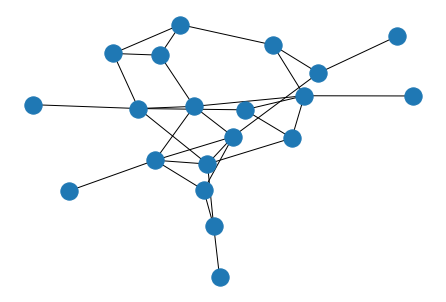

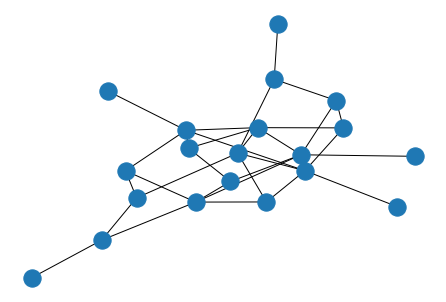

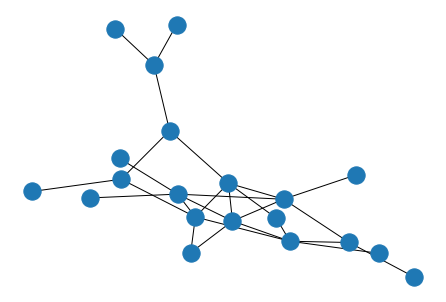

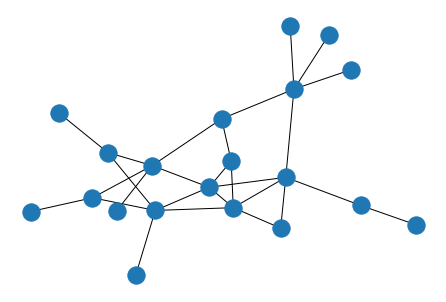

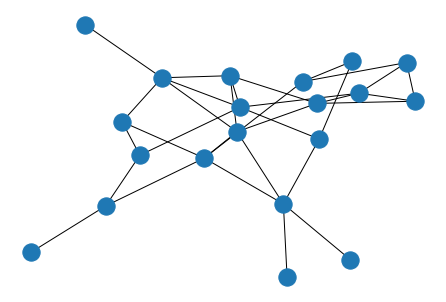

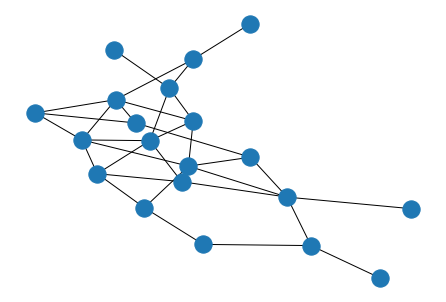

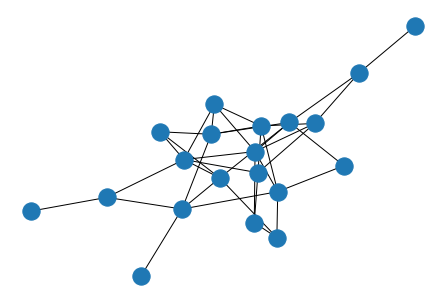

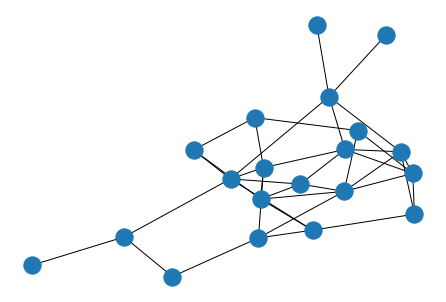

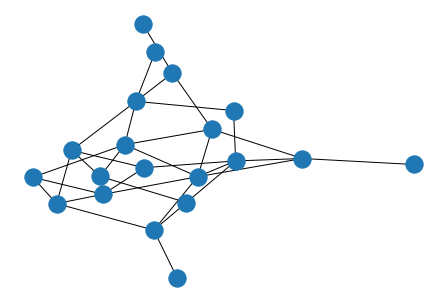

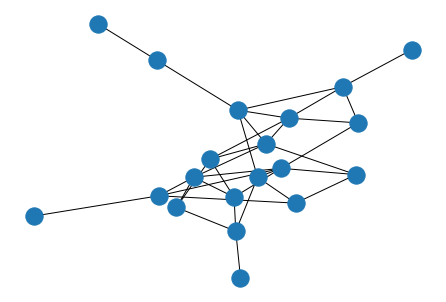

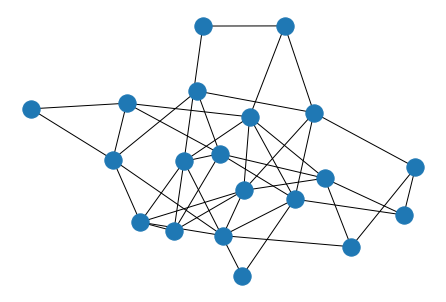

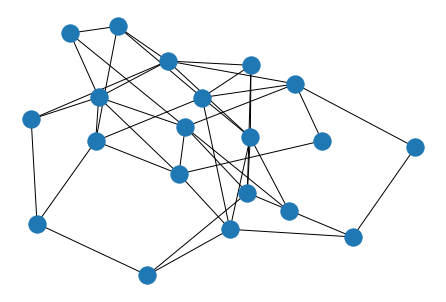

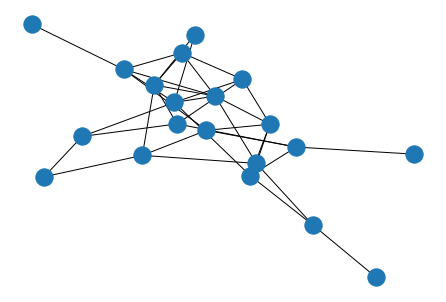

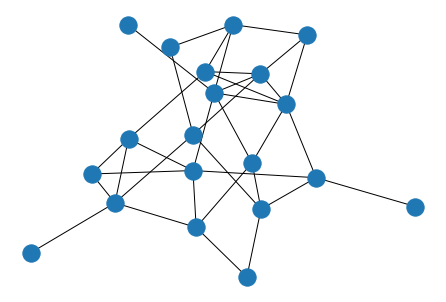

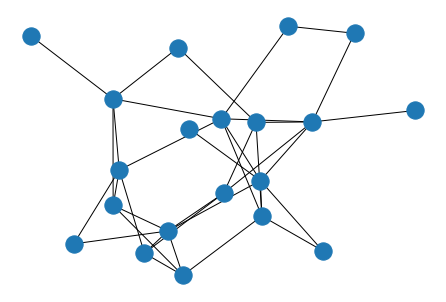

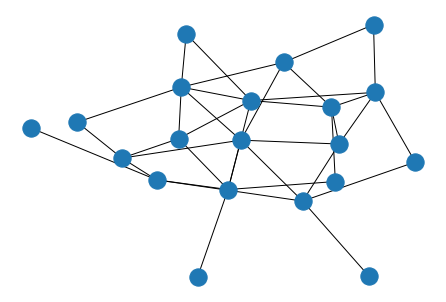

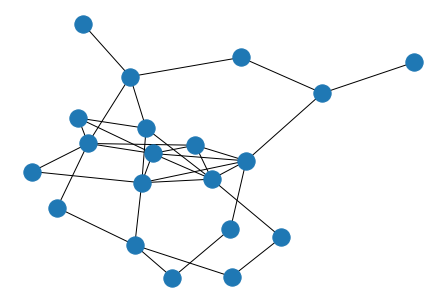

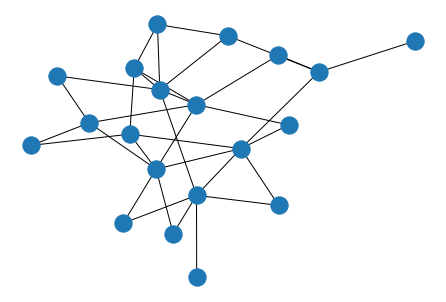

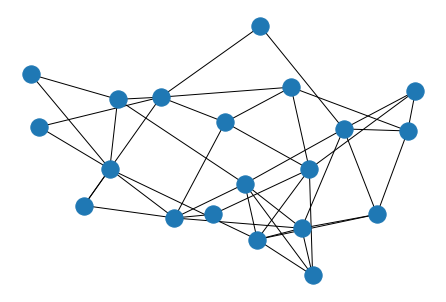

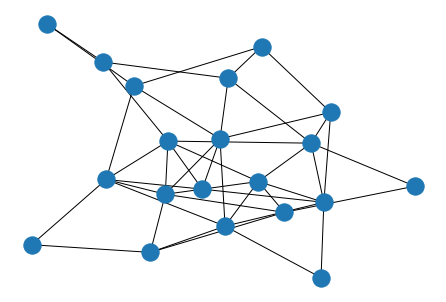

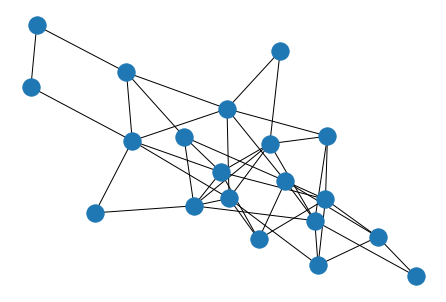

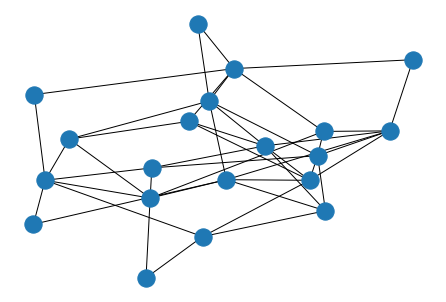

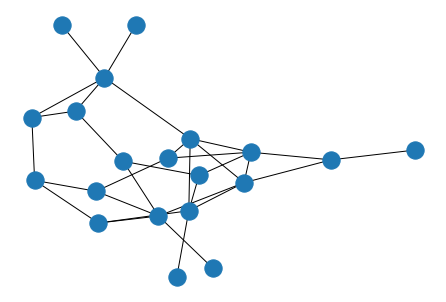

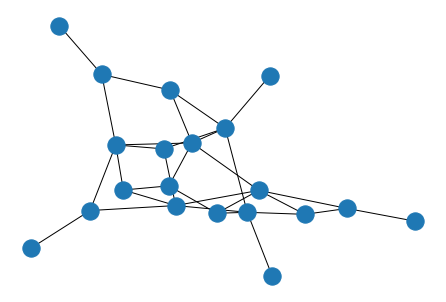

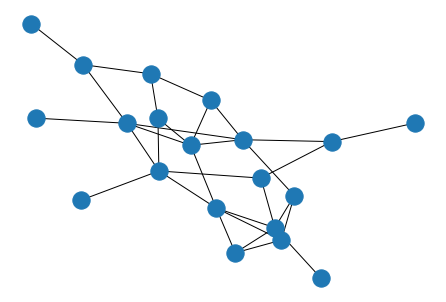

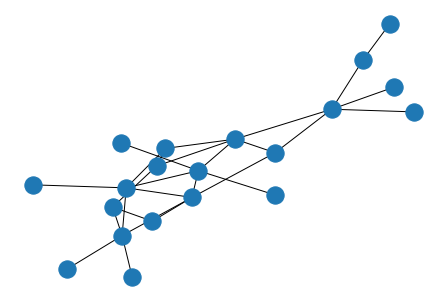

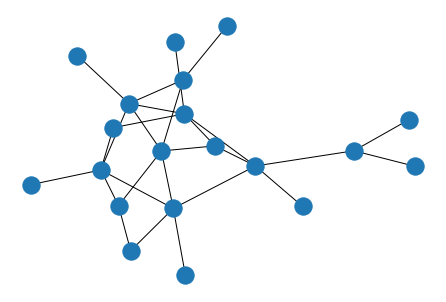

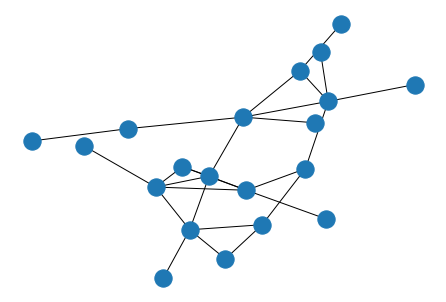

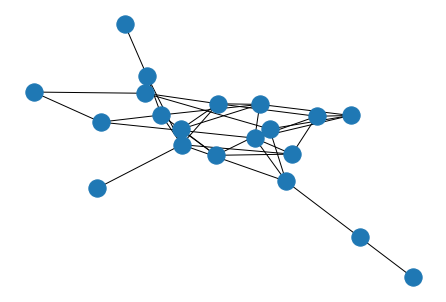

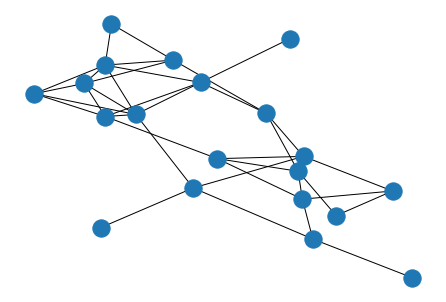

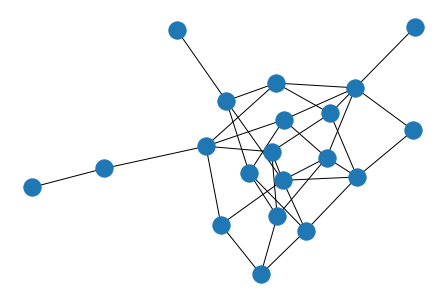

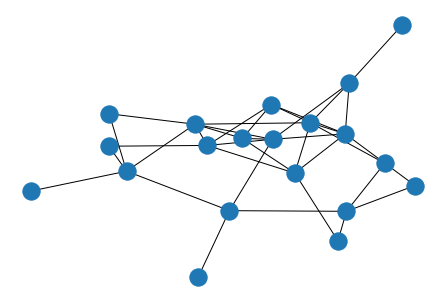

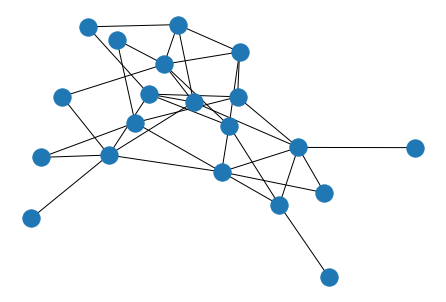

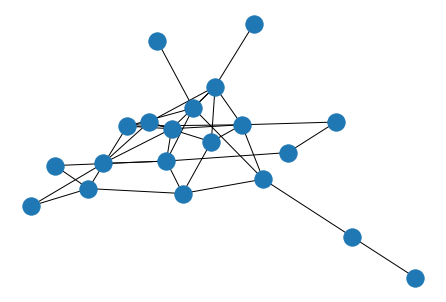

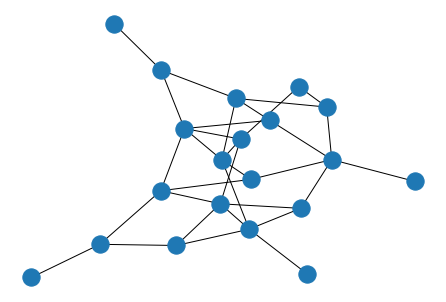

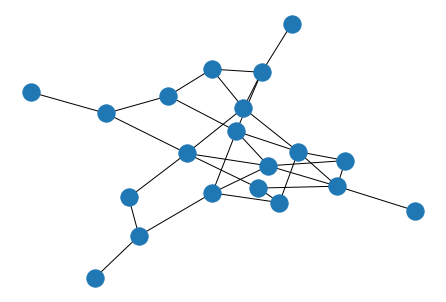

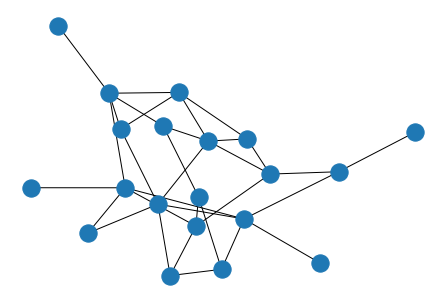

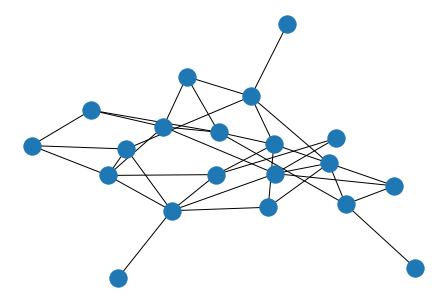

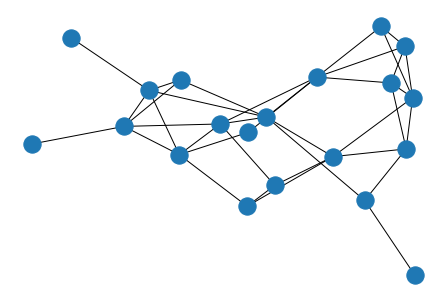

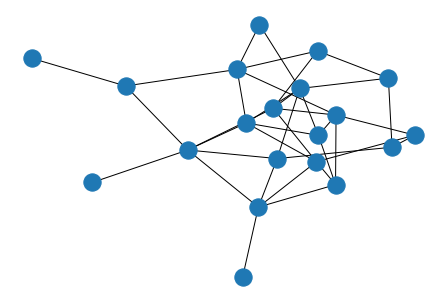

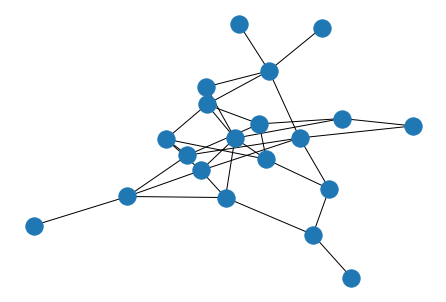

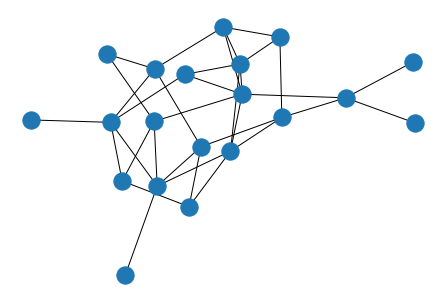

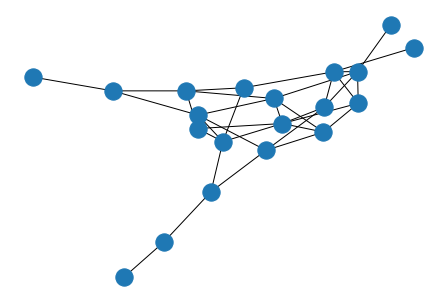

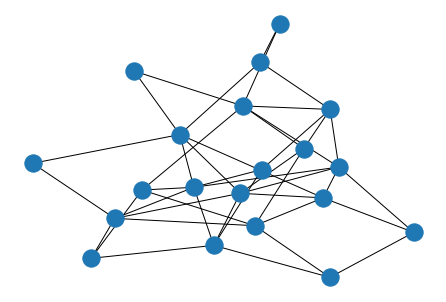

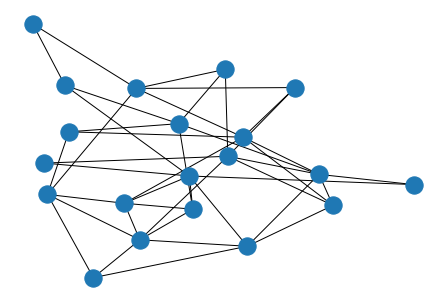

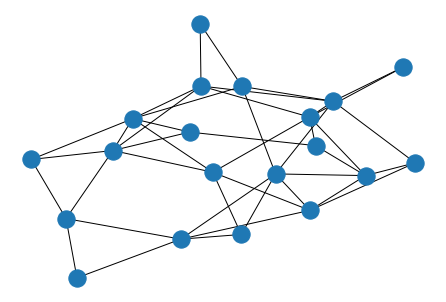

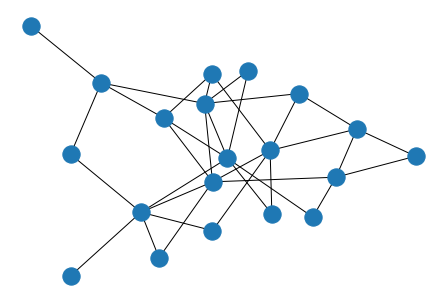

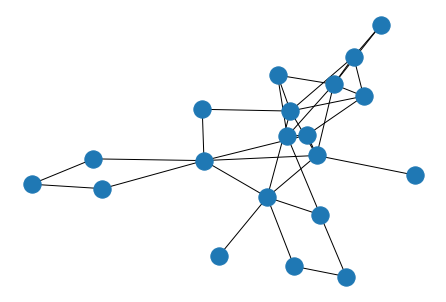

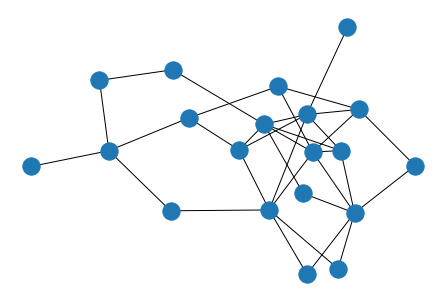

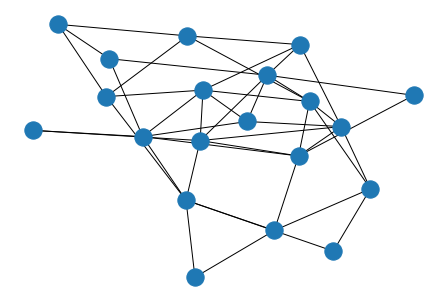

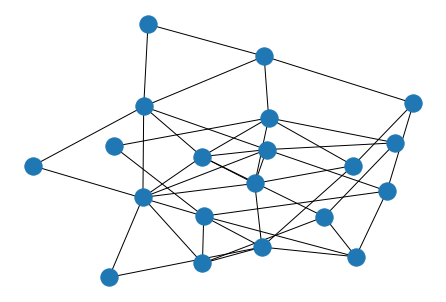

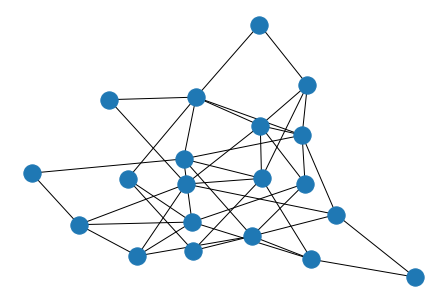

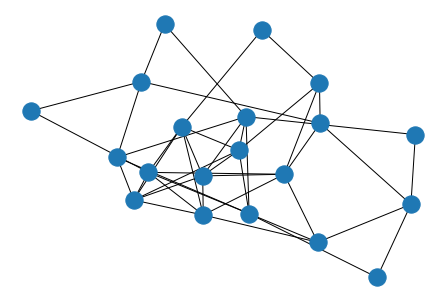

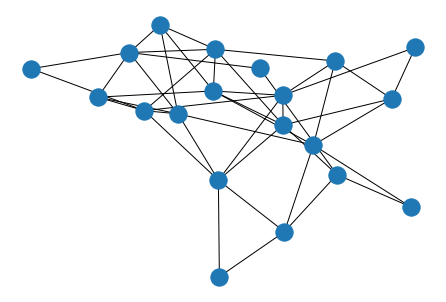

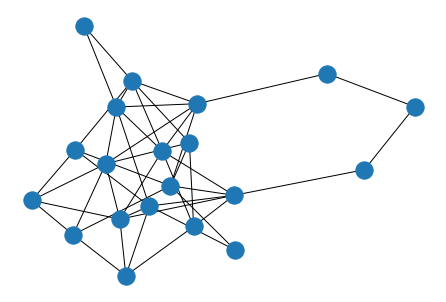

In [21]:
for i in g_list:
  nx.draw(i)
  plt.show()

In [22]:
g_data

[[[0.9126182794570923,
   0.6170626282691956,
   20.284749084257996,
   16.239976114915887],
  [0.41260194778442383,
   0.3829472064971924,
   20.28474895369488,
   14.733520412640924],
  [0.5873814821243286,
   0.11706122010946274,
   20.284749091771697,
   14.901479499449865],
  [0.08740486204624176,
   0.8829466700553894,
   20.284748801905074,
   16.213428867093228],
  [-0.08738067001104355,
   0.6170719861984253,
   20.284748991580365,
   15.491983837986234],
  [0.4126114249229431,
   0.38294562697410583,
   20.284749079417914,
   14.077857145947995],
  [0.4126124680042267,
   0.8829447627067566,
   20.284749087120357,
   16.316271474531682],
  [0.9126180410385132, 0.617055356502533, 20.284749105356, 17.546092431058533],
  [0.41261810064315796,
   0.3829444646835327,
   20.284749105370768,
   15.85270556026846],
  [0.4126182198524475,
   0.3829444646835327,
   20.284749105363407,
   19.62308202049241],
  [0.5873548984527588,
   0.6170579195022583,
   20.284748686315922,
   14.6307

In [23]:
i = 16
j = 0
G1 = g_list[i]
G2 = g_list[j]
g1_results = g_data[i]
g2_results = g_data[j]

similarity(G1, G2, subgraphs = g_all, tranf_mat = tranf_mat)

0.763680403914118

In [24]:
actual_sim(G1, G2,g1_results, g2_results)

array([0.79604899])

In [25]:
for i in range(55):
    print(find_max_energy(g_data[i]))

20.284749105370768
20.502635955801225
18.066398420918414
17.86002664365252
20.864235941178443
20.858653070476944
23.980917630040672
23.838427673621815
22.221382432427987
22.06849600891617
26.780676084021273
26.679933259533694
23.457681076195165
23.25716682150475
22.91554565357199
23.079868335123706
21.81286201725008
21.96574473687494
26.793042762094295
27.183336848383497
27.66213945620647
27.845212736429364
20.334773176913686
20.573426826891534
20.406697224191806
17.85286348497528
18.022779955152135
17.56897217599276
23.338656210439737
22.854887436815865
23.443608667223767
23.10158243276543
23.067116935873962
23.05784920134478
21.160546969459688
21.047016182737273
21.119511380242272
23.570360967601996
23.33135849133972
23.982326041550806
22.214167951626468
22.22565712028168
22.149960921417307
26.879145535277534
26.640141111375648
26.28063042367684
22.06250407244687
21.91218840745617
22.01618259930831
27.38264401263232
26.942664791195305
27.29366403318902
27.37056371932459
27.5860753986

# Plotting Similarity vs Actual Similarity



donor-acceptor pairs are either even-even or odd-odd



**
I'm calling certain graphs even -- those with 16, 18 or 20 even degree nodes-- and certain graphs odd -- those with 0, 2, 4 even degree nodes. The rest are reffered to as mix-parity**

#### Classifying graphs first

In [26]:
ng_list = g_list[:22]

In [27]:
ng_data = g_data[:22]

In [28]:
even_deg = [16, 18,20] 
odd_deg = [0,2,4]

In [29]:
#classifier
def even_or_odd(g, even_deg_nodes = even_deg, odd_deg_nodes = odd_deg):
  """
  Return 0 if a graph is classified as even, 1 if odd , -1 otherwise
  """
  degree_sequence = [d for n, d in g.degree()] 
  even_iter = 0
  for i in degree_sequence:
    if (i%2) ==0:
      even_iter+=1
  if even_iter in even_deg_nodes:
    return 0
  elif even_iter in odd_deg_nodes:
    return 1
  else:
    return -1

def classifier(g_list):
  """
  classifies some graphs as odd, others as even and remaining as mix; returns 
  indices of respective graphs in those bags
  """
  even=[]
  odd= []
  mix = []

  for i in range(len(g_list)):
    g = g_list[i]
    var = even_or_odd(g)
    if var ==0:
      even.append(i)
    elif var ==1:
      odd.append(i)
    else:
      mix.append(i)
  return even, odd, mix

In [30]:
# indices of graphs stores in g_list
even, odd, mix = classifier(g_list)

In [39]:
even = [16, 17, 18, 19, 20 , 21]

In [40]:
odd = [0,1,2,3,4,5]

In [41]:
mix = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [42]:
alll = [i for i in range(len(ng_list))]

In [43]:
alll

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

### Run Funtion General

In [44]:
def run_general(A, B, graphs = ng_list, g_results =ng_data):
  """
  A, B are sets of indices for graphs between which we have to establish tranferability
  """
  xs = []
  ys = []
  a_ss= []
  s_ss = []
  labels = []
  #datas = []


  #first tackling A-B graphs
  for i in A:
    donor = graphs[i]
    donor_results = g_results[i]
    donor_sim = mutual_similarity(G1 = donor)
    for j in B:
    
      acceptor = graphs[j]
      acceptor_results = g_results[j]
      acceptor_sim = mutual_similarity(G1 = acceptor)
      a_sim = actual_sim(donor, acceptor, donor_results, acceptor_results)
      s_sim = similarity(donor, acceptor)
      a_ss.append(a_sim)
      s_ss.append(s_sim)
      # deg1 = graph_index_to_even_deg_nodes(i)
      # deg2 = graph_index_to_even_deg_nodes(j)
      # labels.append(str(deg1) + "->"+str(deg2))
      
      xs.append(donor_sim)
      ys.append(acceptor_sim)
      # deg1 = graph_index_to_even_deg_nodes(i)
      # deg2 = graph_index_to_even_deg_nodes(j)
      # data = [[[x,y]], str(deg1)+'<->'+str(deg2)]
      # datas.append(data)
        
  if A!=B:
    #now tackling B-A graph pairs
    for i in B:
      donor = graphs[i]
      donor_results = g_results[i]
      donor_sim = mutual_similarity(G1 = donor)
      for j in A:
      
        #print('-----------')
        # print(i)
        #print(j)
        acceptor = graphs[j]
        acceptor_results = g_results[j]
        acceptor_sim = mutual_similarity(G1 = acceptor)
        a_sim = actual_sim(donor, acceptor, donor_results, acceptor_results)
        s_sim = similarity(donor, acceptor)
        a_ss.append(a_sim)
        s_ss.append(s_sim)
        #print(y)
        xs.append(donor_sim)
        ys.append(acceptor_sim)
        # deg1 = graph_index_to_even_deg_nodes(i)
        # deg2 = graph_index_to_even_deg_nodes(j)
        # labels.append(str(deg1) + "->"+str(deg2))
        # deg1 = graph_index_to_even_deg_nodes(i)
        # deg2 = graph_index_to_even_deg_nodes(j)
        
          # #data = datas[0]
          # targ_label = str(deg2)+"<->"+str(deg1)

          # k=0
          # while k <len(datas):
          #   data_k = datas[k]
          #   # print('target string is  ' + targ_label)
          #   # print('string is ' + data_k[1])
          #   # print('bool check '+ str(targ_label ==str(data_k[1])))
          #   if str(data_k[1]) == targ_label:
          #     print('k is ' + str(k))
          #     break
          #   #print('no break')
          #   k+=1
          # # print(k)
          # # print(datas)
          # datas[k][0].append([x,y])
  return [xs,ys,a_ss, s_ss]#, labels]

In [46]:
results = run_general(alll, alll)

In [54]:
#@title
def find_similarity(donor_index, acceptor_index, results, g_list=ng_list):
  """
  Having computed results for all pairs, finds results for certain pair
  """
  n = len(g_list)
  i = donor_index*n + acceptor_index
  result = [results[0][i], results[1][i], results[2][i], results[3][i]]# results[4][i] ]
  return result

def find_subresults(A, B, results):
  """
  From all pair results, returns those corresponding to A,B
  """
  xs = []
  ys = []
  a_ss= []
  s_ss = []
  #labels = []

  for i in A:
    for j in B:
      if (i!=j):
        result = find_similarity(i, j, results)
        xs.append(result[0])
        ys.append(result[1])
        a_ss.append(result[2])
        s_ss.append(result[3])
        #labels.append(result[4])

  if A!=B:
    for i in B:
      for j in A:
        if(i!=j):
          result = find_similarity(i, j, results)
          xs.append(result[0])
          ys.append(result[1])
          a_ss.append(result[2])
          s_ss.append(result[3])
          #labels.append(result[4])
  return xs,ys,a_ss, s_ss#, labels

def find_subresults_self(A, results):
  """
  From all pair results, returns those corresponding to A,B
  """
  xs = []
  ys = []
  a_ss= []
  s_ss = []
  #labels = []

  for i in A:
    for j in A:
      if (i==j):
        result = find_similarity(i, j, results)
        xs.append(result[0])
        ys.append(result[1])
        a_ss.append(result[2])
        s_ss.append(result[3])
        #labels.append(result[4])
  return xs,ys,a_ss, s_ss#, labels

In [55]:
results

[[0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9268677837240435,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.9335152679194035,
  0.8677784214494778,
  0.867778

## Results

In [56]:
len(results[0])

484

In [85]:
even = [16,17,18,19,20,21]
odd = [0,1,2,3,4,5]
mix = [6,7,8,9,10,11,12,13,14,15]

In [86]:

#@title
x_odod, y_odod, a_odod, s_odod = find_subresults(odd, odd, results = results)
x_evev, y_evev, a_evev, s_evev = find_subresults(even, even, results = results)
x_same = x_odod + x_evev
y_same = y_odod + y_evev
a_same = a_odod + a_evev
s_same = s_odod + s_evev


In [87]:
#@title
x_diff, y_diff, a_diff, s_diff = find_subresults(odd, even, results = results)
x_self, y_self, a_self, s_self = find_subresults_self(alll,results = results)

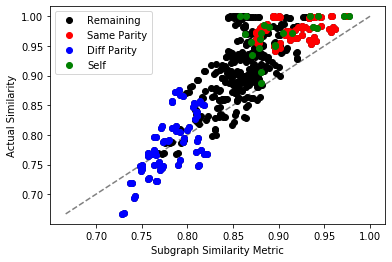

In [88]:
#@title
##########45 degree line ###########
low = min(a_diff+s_diff)
plt.plot([low, 1], [low, 1], color = 'gray', linestyle = '--')
##########################
plt.plot(results[3], results[2], color = 'black', marker = 'o', linestyle = '', label = 'Remaining' )
plt.plot(s_same, a_same, color = 'red', marker = 'o', linestyle = '', label = 'Same Parity')
plt.plot(s_diff, a_diff, color = 'blue', marker = 'o', linestyle = '', label = 'Diff Parity')
plt.plot(s_self, a_self, color = 'green', marker = 'o', linestyle = '', label = 'Self' )

################################
#clb = plt.colorbar()
#clb.ax.set_ylabel('|actual_sim - subgraph_sim|',fontsize=10)
plt.xlabel('Subgraph Similarity Metric')
plt.ylabel('Actual Similarity')
plt.legend()
plt.show()

In [67]:
s_all = results[3]
a_all = [float(i) for i in results[2]]

<Figure size 432x288 with 0 Axes>

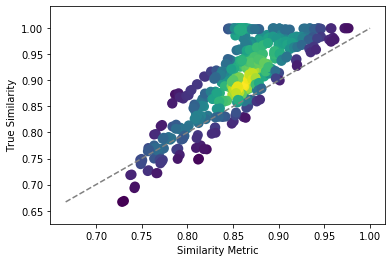

In [68]:
#plt.scatter(beta, gammafrom scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde
fig = plt.figure()

fig = plt.figure(figsize = (6,4))
x =s_all
y = a_all

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# fig, ax = plt.subplots()
plt.scatter(x, y, c=z, s=100, edgecolor='')

low = min(x+y)
plt.plot([low, 1], [low, 1], color = 'gray', linestyle = '--')

plt.xlabel('Similarity Metric')
plt.ylabel('True Similarity')
#plt.legend()
plt.show()
#fig.savefig("fig_Density_of_Simlarity_Pairs_20_node_random.png", dpi = 100)

In [60]:
iterr=0
total =0
for i in range(len(results[0])):
  total+=1
  if results[2][i]>0.98:
    iterr+=1
print('Pairs that have high actual similarity: '+ str(iterr)+'/'+str(total) + " which is " +str(100*(iterr/total))+ str('%'))

Pairs that have high actual similarity: 108/484 which is 22.31404958677686%


# Mutual Tranferability

In [70]:
min(y_all)

0.8493164495245261

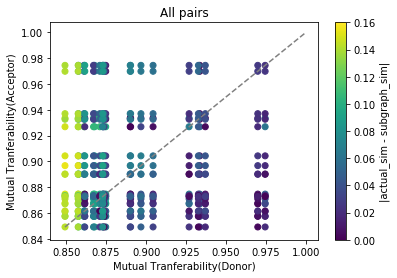

In [74]:
#@title
x_all,y_all,a_all,s_all = results
x = x_all
y = y_all
a= a_all
s = s_all
title = 'All pairs'
##########45 degree line ###########
low = min(x+y)
plt.plot([low, 1], [low, 1], color = 'gray', linestyle = '--')
###########################################
d = [a[i]-s[i] for i in range(len(x))]
new_d = [abs(float(i)) for i in d]
plt.scatter(x,y, c = new_d, vmin = 0, vmax = .16)
################################
clb = plt.colorbar()
clb.ax.set_ylabel('|actual_sim - subgraph_sim|',fontsize=10)
plt.xlabel('Mutual Tranferability(Donor)')
plt.ylabel('Mutual Tranferability(Acceptor)')
plt.title(title)
plt.show()

In [73]:
max(new_d)

0.154845000986236

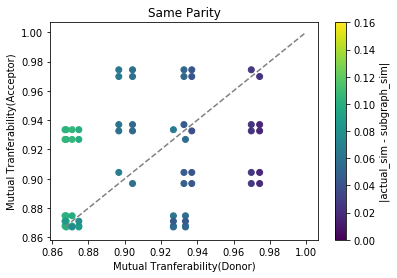

In [75]:
#@title
x = x_same
y = y_same
a= a_same
s = s_same
title = 'Same Parity'
##########45 degree line ###########
low = min(x+y)
plt.plot([low, 1], [low, 1], color = 'gray', linestyle = '--')
###########################################
d = [a[i]-s[i] for i in range(len(x))]
new_d = [abs(float(i)) for i in d]
plt.scatter(x,y, c = new_d, vmin = 0, vmax = .16)
################################
clb = plt.colorbar()
clb.ax.set_ylabel('|actual_sim - subgraph_sim|',fontsize=10)
plt.xlabel('Mutual Tranferability(Donor)')
plt.ylabel('Mutual Tranferability(Acceptor)')
plt.title(title)
plt.show()

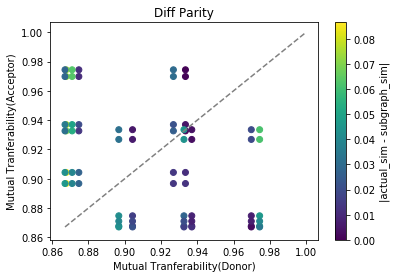

In [77]:
#@title
x = x_diff
y = y_diff
a= a_diff
s = s_diff
title = 'Diff Parity'
##########45 degree line ###########
low = min(x+y)
plt.plot([low, 1], [low, 1], color = 'gray', linestyle = '--')
###########################################
d = [a[i]-s[i] for i in range(len(x))]
new_d = [abs(float(i)) for i in d]
plt.scatter(x,y, c = new_d, vmin = 0)
################################
clb = plt.colorbar()
clb.ax.set_ylabel('|actual_sim - subgraph_sim|',fontsize=10)
plt.xlabel('Mutual Tranferability(Donor)')
plt.ylabel('Mutual Tranferability(Acceptor)')
plt.title(title)
plt.show()

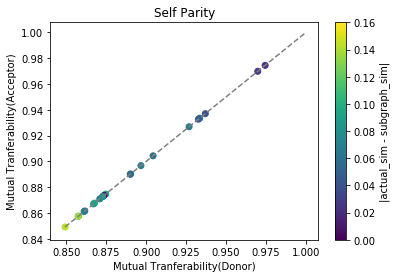

In [89]:
#@title
x = x_self
y = y_self
a= a_self
s = s_self
title = 'Self Parity'
##########45 degree line ###########
low = min(x+y)
plt.plot([low, 1], [low, 1], color = 'gray', linestyle = '--')
###########################################
d = [a[i]-s[i] for i in range(len(x))]
new_d = [abs(float(i)) for i in d]
plt.scatter(x,y, c = new_d, vmin = 0, vmax = .16)
################################
clb = plt.colorbar()
clb.ax.set_ylabel('|actual_sim - subgraph_sim|',fontsize=10)
plt.xlabel('Mutual Tranferability(Donor)')
plt.ylabel('Mutual Tranferability(Acceptor)')
plt.title(title)
plt.show()

In [90]:
len(results)

4

In [92]:
a_file = open("T1_local_20_20NodeGraphs.txt", "w")
for row in results:
        np.savetxt(a_file, row)
a_file.close()